[Leo's Home page](https://leomrocha.github.com) -- [Github Page](https://github.com/leomrocha/neural-representations) -- License: [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

# Binding and Unbinding Vectors

[Leonardo M. Rocha](https://leomrocha.github.com)

[Contact Me](https://leomrocha.github.io/contact/)

## Introduction

This notebook has as purpose to show the binding and unbinding of vectors.

In signal processing [convolution](https://en.wikipedia.org/wiki/Convolution) and [deconvolution](https://en.wikipedia.org/wiki/Deconvolution) are widely used in all types of signals. While in Artificial Neural Networks (ANNs) they are mostly used in  computer vision (although some implementations are not strictly a convolution operation) they are not commonly used in the study of embeddings.

This notebook focus on implementing a convolution and its reverse deconvolution operation in order to be able to _bind_ and _unbind_ vectors to get some inspiration for ANNs.  This is inspired by the work presented in [Neural Engineering](https://mitpress.mit.edu/books/neural-engineering) by _Eliasmith & Anderson_.


The notebooks can be found at the [neural-representation repo](https://github.com/leomrocha/neural-representations) and the completed code and all the tests are available at [minibrain's sequence directory](https://github.com/leomrocha/minibrain/blob/master/predictors/sequence/convolutions.py)



In [1]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Circular Convolution Definition
#adapted from here https://github.com/fchollet/keras/issues/2518
# and https://stackoverflow.com/questions/35474078/python-1d-array-circular-convolution
#copied from:
#https://stackoverflow.com/questions/17473917/is-there-a-equivalent-of-scipy-signal-deconvolve-for-2d-arrays

def holographic_merge(x,y):
    x_fft = fft.fftshift(fft.fftn(x))
    y_fft = fft.fftshift(fft.fftn(y))
    return fft.fftshift(fft.ifftn(fft.ifftshift(x_fft*y_fft)))

def holographic_unmerge(z, y):
    z_fft = fft.fftshift(fft.fftn(z))
    y_fft = fft.fftshift(fft.fftn(y))
    return np.around(fft.fftshift(fft.ifftn(fft.ifftshift(z_fft/y_fft))),14)

#Lessons Learned:
# - Convolution and Deconvolution precision depend on each other (deconv will have less)
# - I was missing the fftshift part also .... I NEED TO REVIEW MORE MATH! 

Here some random values and made the matrix a bit sparse to lightly simulate what would happen in the brain. 

In [3]:
Ar, Ai = np.concatenate([np.random.random(2), np.zeros(3), 
                         np.random.random(1), np.zeros(4)]), np.zeros(10)
Br, Bi = np.concatenate([np.zeros(2), np.random.random(3),
                        np.zeros(1), np.random.random(2), np.zeros(2)]), np.zeros(10)

In [4]:
x = np.vectorize(complex)(Ar,Ai)
y = np.vectorize(complex)(Br,Bi)

In [5]:
x.shape, y.shape, Ar,Br

((10,),
 (10,),
 array([0.9731084 , 0.45245477, 0.        , 0.        , 0.        ,
        0.81200172, 0.        , 0.        , 0.        , 0.        ]),
 array([0.        , 0.        , 0.3386613 , 0.99856387, 0.00930009,
        0.        , 0.79260153, 0.76094083, 0.        , 0.        ]))

Merging vectors in order _x,y_

In [6]:
z =  holographic_merge(x,y)

The result is the same dimension as the inputs, preserving embedded dimension space is important in ANN applications.

In [7]:
z.shape, z

((10,),
 array([0.00420787+2.59254116e-18j, 0.77128721+2.06396263e-17j,
        1.37408781-6.55639282e-17j, 1.15512688-1.04606639e-17j,
        0.00755169+8.22918004e-17j, 0.        +1.09010266e-17j,
        0.6435938 -2.20032568e-17j, 0.94743941+4.17451538e-17j,
        1.12493981+3.68886173e-18j, 0.46085498-6.38311611e-17j]))

Now unbinding the vectors and recovering the original (still the problem here is that there is the need to have the las added value to the convolution)

In [8]:
xp = holographic_unmerge(z,y)

In [9]:
x.real

array([0.9731084 , 0.45245477, 0.        , 0.        , 0.        ,
       0.81200172, 0.        , 0.        , 0.        , 0.        ])

In [10]:
xp.real

array([ 0.9731084 ,  0.45245477,  0.        ,  0.        ,  0.        ,
        0.81200172,  0.        , -0.        ,  0.        , -0.        ])

## Gotcha!
After fighting with too many issues wiht the previous implementations I've found that
with Scipy there is somebody that managed to do it correctly
https://stackoverflow.com/questions/17473917/is-there-a-equivalent-of-scipy-signal-deconvolve-for-2d-arrays

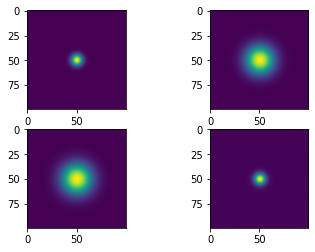

In [11]:
#copied from:
#https://stackoverflow.com/questions/17473917/is-there-a-equivalent-of-scipy-signal-deconvolve-for-2d-arrays

from scipy import fftpack
from scipy import stats

sx, sy = 100, 100
X, Y = np.ogrid[0:sx, 0:sy]
star = stats.norm.pdf(np.sqrt((X - sx/2)**2 + (Y - sy/2)**2), 0, 4)
psf = stats.norm.pdf(np.sqrt((X - sx/2)**2 + (Y - sy/2)**2), 0, 10)

def convolve(star, psf):
    star_fft = fftpack.fftshift(fftpack.fftn(star))
    psf_fft = fftpack.fftshift(fftpack.fftn(psf))
    return fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(star_fft*psf_fft)))

def deconvolve(star, psf):
    star_fft = fftpack.fftshift(fftpack.fftn(star))
    psf_fft = fftpack.fftshift(fftpack.fftn(psf))
    return fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(star_fft/psf_fft)))

star_conv = convolve(star, psf)
star_deconv = deconvolve(star_conv, psf)

f, axes = plt.subplots(2,2)
axes[0,0].imshow(star)
axes[0,1].imshow(psf)
axes[1,0].imshow(np.real(star_conv))
axes[1,1].imshow(np.real(star_deconv))
plt.show()

In [12]:
z = convolve(x,y)

In [13]:
xp = deconvolve(z,y)

In [14]:
np.around([xp.real, x.real], 15)

array([[ 0.9731084 ,  0.45245477,  0.        , -0.        ,  0.        ,
         0.81200172, -0.        ,  0.        ,  0.        , -0.        ],
       [ 0.9731084 ,  0.45245477,  0.        ,  0.        ,  0.        ,
         0.81200172,  0.        ,  0.        ,  0.        ,  0.        ]])

In [15]:
yp = deconvolve(z,x)

In [16]:
np.around([y.real,yp.real], 15)

array([[ 0.        ,  0.        ,  0.3386613 ,  0.99856387,  0.00930009,
         0.        ,  0.79260153,  0.76094083,  0.        ,  0.        ],
       [ 0.        , -0.        ,  0.3386613 ,  0.99856387,  0.00930009,
         0.        ,  0.79260153,  0.76094083,  0.        , -0.        ]])

## Conclusion

The present code is able to bind and unbind vectors preserving order. This is important for events that must be taken into account in order.

The code is shown to work for one and two dimensional vector spaces, it can be extended for more dimensions.

While implementing this I had to review math and working with discrete signals which has some gotchas I didn't remember at the moment, for example having to shift the signal.